## Attribution

This section covers more details on attributions using the fitted model object:

1. meaning of the output dataframes
2. what-if scenario generation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

from karpiu.explainability import Attributor

pd.set_option('display.float_format', lambda x: '%.5f' % x)
np.set_printoptions(suppress=True)
pd.set_option('display.max_rows', 50)

In [2]:
%load_ext autoreload
%autoreload 2

To star with, we need a fitted MMM and we can reuse the one we fitted from the previous `Quickstart` section.

In [3]:
with open ('./resource/model.pkl', 'rb') as f:
    mmm = pickle.load(f)

After that, users need to specify the interval for the attribution period.

### Attribution on Historic Performance

In [4]:
ATTR_START = '2019-03-01'
ATTR_END = '2019-03-31'

spend_cols = mmm.get_spend_cols()
channels = ['organic'] + spend_cols

 Then users can utilize `Attributor.make_attribution()` to derive attribution summary. There are four output dataframes here:

 1. `activities_attr_df`: attribution against sales date
 2. `spend_attr_df`: attribution against spend date
 3. `spend_df`: spend against spend date (original input)
 4. `cost_df`: cost per sales against spend date (output item 3 divided by output item 2)

 The difference between output item 1 and output item 2 is that item 1 describes attribution against the date the sales actually happened while item 2 is from the accounting prospective -- it describes the attribution against the date when the spend tied to such attribution happened.

 In the case where there is no adstock in the model, one should expect these two output items are identical.

In [5]:
attr_obj = Attributor(mmm, start=ATTR_START, end=ATTR_END)
activities_attr_df, spend_attr_df, spend_df, cost_df = attr_obj.make_attribution()

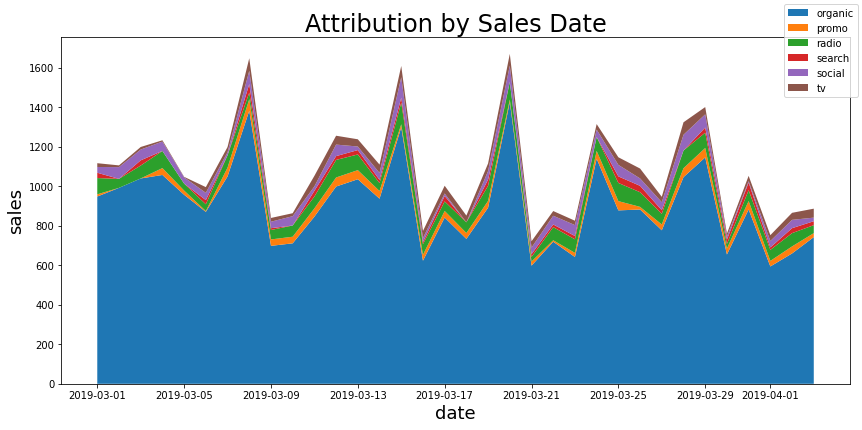

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.stackplot(
    activities_attr_df['date'].values, 
    activities_attr_df[channels].values.transpose(), 
    labels=channels
)
ax.set_title("Attribution by Sales Date", fontdict={'fontsize': 24})
ax.set_xlabel("date", fontdict={'fontsize': 18})
ax.set_ylabel("sales", fontdict={'fontsize': 18})
fig.legend()
fig.tight_layout()

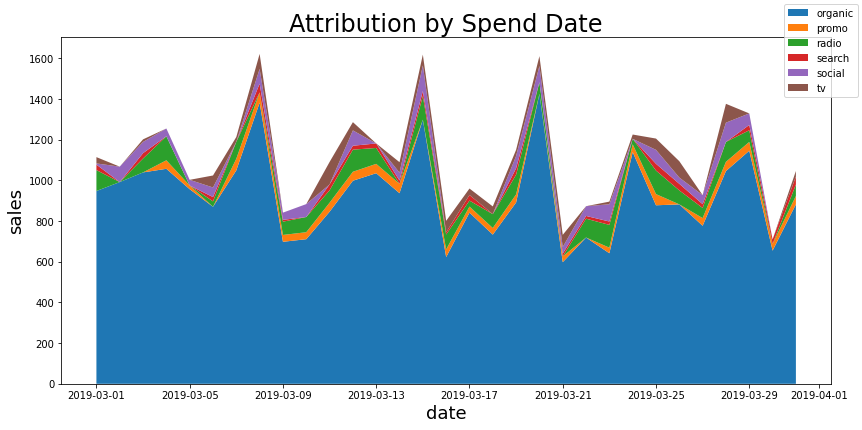

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.stackplot(
    spend_attr_df['date'].values, 
    spend_attr_df[channels].values.transpose(), 
    labels=channels
)
ax.set_title("Attribution by Spend Date", fontdict={'fontsize': 24})
ax.set_xlabel("date", fontdict={'fontsize': 18})
ax.set_ylabel("sales", fontdict={'fontsize': 18})
fig.legend()
fig.tight_layout()

### Attribution on Future Performance with Model Prediction

Users can also use attribution on future predictions from the model. This simply means making attribution on predicted response since the actual response has not been observed yet. The first step is to create the data frame contains future information needed to make prediction. The package offers a utilities to make future features by rolling mean.

In [8]:
from karpiu.utils import extend_ts_features

N_PERIODS = 180
df = mmm.get_raw_df()
extended_df = df[['date'] + spend_cols]
extended_df = extend_ts_features(extended_df, n_periods=N_PERIODS, date_col='date', rolling_window=30)
extended_df.tail(10)

,date,promo,radio,search,social,tv
1265,2022-06-19,1905.00000,2614.00000,388.00000,2640.50000,6527.00000
1266,2022-06-20,1905.00000,2614.00000,388.00000,2640.50000,6527.00000
1267,2022-06-21,1905.00000,2614.00000,388.00000,2640.50000,6527.00000
1268,2022-06-22,1905.00000,2614.00000,388.00000,2640.50000,6527.00000
1269,2022-06-23,1905.00000,2614.00000,388.00000,2640.50000,6527.00000
1270,2022-06-24,1905.00000,2614.00000,388.00000,2640.50000,6527.00000
1271,2022-06-25,1905.00000,2614.00000,388.00000,2640.50000,6527.00000
1272,2022-06-26,1905.00000,2614.00000,388.00000,2640.50000,6527.00000
1273,2022-06-27,1905.00000,2614.00000,388.00000,2640.50000,6527.00000
1274,2022-06-28,1905.00000,2614.00000,388.00000,2640.50000,6527.00000


Then the next step is to make prediction and relabel it as the response column.

In [9]:
pred_df = mmm.predict(extended_df)
expected_sales = np.concatenate([df['sales'].values, pred_df['prediction'].values[-N_PERIODS:]])
extended_df['sales'] = expected_sales

With the extended dataframe, users can input it into the Attributor as external data and follow the previous syntax to make attribution.

In [10]:
ATTR_START = '2022-01-01'
ATTR_END = '2022-04-30'

attr_obj = Attributor(mmm, start=ATTR_START, end=ATTR_END, df=extended_df)
activities_attr_df, spend_attr_df, spend_df, cost_df = attr_obj.make_attribution()

In [11]:
spend_attr_df.tail(10)

,date,organic,promo,radio,search,social,tv
110,2022-04-21,996.52615,39.83508,53.13192,14.60332,54.34514,35.31363
111,2022-04-22,996.84461,39.84780,53.14887,14.60798,54.36249,35.32489
112,2022-04-23,997.16233,39.86050,53.16578,14.61264,54.37980,35.33612
113,2022-04-24,997.47936,39.87317,53.18266,14.61729,54.39707,35.34734
114,2022-04-25,997.79573,39.88581,53.19950,14.62192,54.41431,35.35853
115,2022-04-26,998.11149,39.89842,53.21632,14.62655,54.43152,35.36969
116,2022-04-27,998.42666,39.91102,53.23310,14.63117,54.44869,35.38084
117,2022-04-28,998.74129,39.92359,53.24985,14.63578,54.46584,35.39197
118,2022-04-29,999.05540,39.93614,53.26658,14.64038,54.48296,35.40309
119,2022-04-30,999.36903,39.94868,53.28328,14.64498,54.50005,35.41419
